# Exercise 5: Model Predictive Control (MPC) for Smart Buildings

## Overview

In this exercise, we leverage Model Predictive Control (MPC) to design a simple controller for heating single building zone. The building envelope is modelled with an interpretable $RC$ model. The aim is to build intuition on MPC design, examine how electricity prices affect control actions, compare soft versus hard constraint formulations, and benchmark **open-loop** MPC with **receding-horizon** MPC under model noise and error.

## Set up

Load the required libraries and 10-minute measurement data from an occupied, semi-detached house in the UK [1] (change the ```data_path``` variable accordingly). An auxiliary function to create electricity prices based on time-of-use (ToU) tariff is also defined.

[1] Hollick, F; Wingfield, J; (2018) Two periods of in-situ measurements from an occupied, semi-detached house in the UK [Dataset]. 10.14324/000.ds.10087216.

In [1]:
# Import libraries
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Plotting figures default
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,4)

# Auxiliary functions
def build_price_profile(time_index, off=0.08, mid=0.20, peak=0.50):
    """
    Given a pandas DatetimeIndex, build a 1D price array with:
      - 'off' during night,
      - 'mid' during working hours,
      - 'peak' during early evening.
    Hours can be adjusted below.
    """
    price = np.zeros(len(time_index))
    
    for k, t in enumerate(time_index):
        h = t.hour
        if 17 <= h < 20:
            price[k] = peak
        elif 7 <= h < 17:
            price[k] = mid
        else:
            price[k] = off
    return price

In [2]:
# Load measurement data
data_path = 'C:\\Users\\ucbva19\\Git projects\\BENV0092\\data raw'
raw_data = pd.read_csv(f'{data_path}\\10mins_solpap_2016.csv', index_col = 0)
raw_data.index = pd.to_datetime(raw_data.index, format="%d/%m/%Y %H:%M")

# Fill missing data with linear interpolation
data = raw_data.copy().interpolate('linear')
assert(data.isna().all().sum() == 0)

# Lead T_in values (target variable)
data['T_Average_lead_1'] = data['T_Average (degC)'].shift(-1)
data['T_diff'] = data['T_External (degC)'] - data['T_Average (degC)']

# Drop NaNs created from the shift operator
data = data.dropna()

# discretization step at 10 minutes
dt_h = 1/6

T_in  = data['T_Average (degC)'].values          # °C
T_out = data['T_External (degC)'].values         # °C
u     = data['P_tot (W)'].values        # kW
t_idx = data.index

## RC Model

As in Exercise 3, we use a single-zone linear model, *ignoring solar radiation* gains for simplicity:
<center>
$
    \Delta T_k := 
T_{k+1}-T_{k}
= \alpha_1(T_{\mathrm{ext},k} - T_{k})
+ \alpha_2 u_k,
$    
</center>

Where:
- $T_k$ : indoor temperature (°C), **state**
- $u_k$ : heating power input (kW), **control**
- $T_{\mathrm{ext}, k}$ : outdoor temperature forecast (°C), **disturbance**
- $w_k$ : process noise (°C), modeling unmodeled gains/losses

As $\alpha_1$ increases, the envelope becomes ``leakier,'' whereas as $\alpha_2$, heat gains increase.
For this exercise, we consider the following values
- $\alpha_1 = 0.0208,$
- $\alpha_{2} = 0.16,$
which correspond to a typical small/medium dwelling.

---

## MPC Optimization Problem Formulation

Next, we formulate the optimization problem that is part of the MPC controller.

**Goal:** minimize total *electricity costs* over a horizon of $N$ steps, while ensuring indoor temperature remains within a thermal comfort band.

**Assumptions:**
- Heating is an electric load (e.g., heat pump).
- The control variable is the heating power (kW).
- The $RC$ model is correct and disturbances are perfectly known. These assumptions will be relaxed later on.

**Price tariff scenarios:**
- Fixed price
- Time-of-use (ToU) price

We compare two approaches:
- MPC with hard constraints
- MPC with soft constraints for thermal comfort violations

---

### Hard Constraints

#### Objective function

The objective function represents the total cost of electricity over the $N$ steps:
\begin{aligned}
\sum_{k=0}^{N-1} p_k\,u_k\, \Delta t,
\end{aligned}
where $p_k$ is the $k$th step electricity prices (£/KWh), and $\Delta t$ is the timestep (hours).

#### Constraints

- **Thermal comfort**: we constrain the indoor temperature within a comfort band
\begin{aligned}
T_{\min} \leq T_{k} \leq T_{\max}, \quad k=0,\dots, N-1,
\end{aligned}
where $T_{\min}, T_{\max}$ are user-defined.
- **Equipment**: we further constrain heating power
\begin{aligned}
u_{\min} \le u_k \le u_{\max}, \quad  k=0,\dots,N-1,
\end{aligned}
where $u_{\min}, u_{\max}$ are the equipment's technical limits.
- **State transition**: we use the $RC$ model described above.

#### Formulation

The MPC problem that optimizes heating operation to minimize electricity costs is given by

\begin{aligned}
\texttt{MPC}:
\min_{u_k}\quad &
\sum_{k=0}^{N-1}
p_k u_k \Delta t, &
\\[6pt]
\text{s.t.}\quad
&
T_{k+1} = T_{k}
+ \alpha_1 (T_{\text{out}, k} - T_{k})
+ \alpha_2 u_k, & k = 0,\dots,N-1,
\\
&
T_{\min} \le T_{k+1} \le T_{\max}, &  k=0,\dots,N-1,
\\
&
0 \le u_k \le u_{\max}, &  k=0,\dots,N-1.
\end{aligned}
This is a **linear programming (LP)** problem that is easily solved with off-the-shelf solvers.

The `build_hard_mpc()` function constructs the optimization problem using the `cvxpy` library. Most problem parameters are considered fixed (e.g., equipment limits) and are defined as constants. We allow a few parameters to vary with time by declaring them as `cp.Parameter`, namely, initial temperature $T_0$, market prices $p_k$, and external temperatures $T_{\textrm{ext}}$. This provides computational benefits when solving multiple problem instances (i.e., solving the same problem with different parameter values).

In [3]:
def build_hard_mpc(N, alpha_1, alpha_2, T_min, T_max, u_min, u_max, dt_minutes = 10):
    # Use CVXPY to create an optimization problem 
    
    # ---------- Parameters (period-varying) ----------
    T0 = cp.Parameter((), nonneg=True, name='T0')
    T_out = cp.Parameter((N), name='T_out')
    prices = cp.Parameter((N), nonneg=True, name='prices')

    dt_h = dt_minutes / 60.0
    
    # Declare variables
    T = cp.Variable((N+1), name='T')
    u = cp.Variable(N, name = 'u')

    ##### Add problem constraints
    constraints = []

    ##### Create an expression for energy_cost (will be minimized)
    energy_cost = None
    
    cost = energy_cost

    prob = cp.Problem(cp.Minimize(cost), constraints)

    return prob    

### Soft Constraints

- **Slack variables:** adding hard constraints on temperature may lead to infeasible formulations.
In this iteration, we allow *soft violations* by introducing non-negative slack variables $s_k^-, s_k^+$.
The upward slack ${s_k^+}$ represents the allowed violations of the upper bound. 
Similarly, ${s_k^-}$ represents the allowed violations of the lower bound.
We modify the thermal constraints as follows
\begin{aligned}
& T_{\min} - {s_k^-} 
\leq T_{k} \leq T_{\max} + {s_k^+}, 
\\
& {s_k^+} \geq 0,\quad {s_k^-} \geq 0.
\end{aligned}

- **Penalty function**: we penalize these thermal comfort violations using a quadratic penalty weighted by a factor $\lambda_s$, which is a user-defined hyperparameter:
\begin{aligned}
{\lambda_s \sum_k \bigl[(s_k^+)^2 + (s_k^-)^2\bigr]},
\end{aligned}

#### Formulation

The soft-constrained MPC problem is given by

\begin{aligned}
\texttt{softMPC}:
\min_{u_k,s_k^+,s_k^-}\quad &
\sum_{k=0}^{N-1}
\left(
\underbrace{p_k u_k \Delta t}_{\textrm{elec. cost}}
+ \underbrace{{\lambda_s\bigl((s_k^+)^2+(s_k^-)^2\bigr)}}_{\textrm{violations}}
\right),& 
\\[6pt]
\text{s.t.}\quad
&
T_{k+1} = T_{k}
+ \alpha_1 (T_{\text{out}, k} - T_{k})
+ \alpha_2 u_k, & k=0,\dots,N-1,
\\
&
T_{\min} - {s_k^-} \le T_{k+1} \le T_{\max} + {s_k^+},& k=0,\dots,N-1,
\\
&
u_{\min} \le u_k \le u_{\max}, & k=0,\dots,N-1.
\end{aligned}

This is a **convex quadratic program**, easily solved with off-the-shelf solvers.
When $\lambda_s → \infty $, the solution of $\texttt{softMPC}$ converges to the one of $\texttt{MPC}$.

The `build_soft_mpc()` constructs the optimization problem using the `cvxpy` library, as above.

In [4]:
def build_soft_mpc(N, alpha_1, alpha_2, T_min, T_max, 
                   u_min, u_max, dt_minutes = 10, lambda_slack = 0.1):

    # ---------- Parameters (period-varying) ----------
    T0 = cp.Parameter((), nonneg=True, name='T0')
    T_out = cp.Parameter((N), name='T_out')
    prices = cp.Parameter((N), nonneg=True, name='prices')

    dt_h = dt_minutes / 60.0

    ### Variables
    T = cp.Variable((N+1), name='T')
    u = cp.Variable(N, name = 'u')
    s_plus = cp.Variable(N, nonneg=True, name = 's_plus')
    s_minus = cp.Variable(N, nonneg=True, name = 's_minus')

    ### Create constraint functions
    constraints = []

    #### Create an expression for energy_cost and comfort penalty
    energy_cost = None
    comfort_penalty = None

    cost = energy_cost + comfort_penalty
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    return prob

## Experimental Parameters Setup

The following cell determines the user-defined problem parameters.

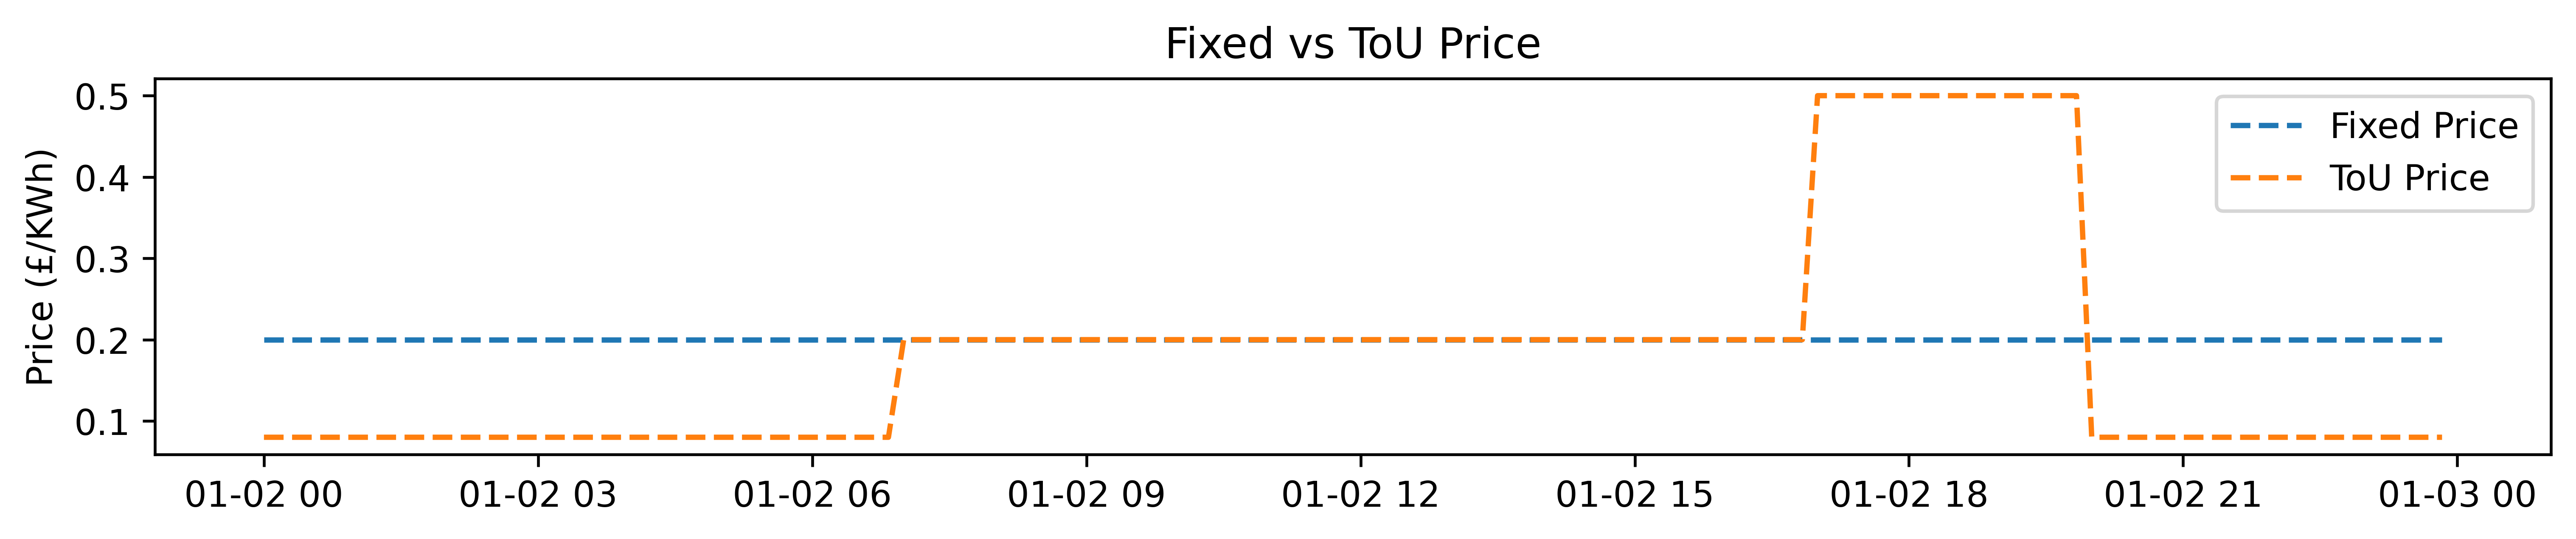

In [5]:
dt_minutes = 10
dt_hours = dt_minutes / 60
steps_per_hour = int(60 / dt_minutes)

start = 24 * 6        # starting point (skip the first day to avoid warm-up)

N_hours = 24          # choose how many hours to optimize over
N_steps = N_hours * steps_per_hour      # Example: 24 hours * 6 steps/hour = 144 steps at 10-min

T_out_MPC = T_out[start:start+N_steps]
time_index = t_idx[start:start+N_steps]

# ---- Constraint parameters (defined by equipment, user preferences, and fitted RC model) ------

# --- RC model parameters ---
alpha_1 = 0.0208   # envelope leak (10-min step)
alpha_2 = 0.16     # heating gain (°C per kW per 10-min)
# alpha_1 = 0.00371049   # envelope leak (10-min step)
# alpha_2 = 0.13859607     # heating gain (°C per kW per 10-min)

# Comfort bounds
T_min = 20.0
T_max = 23.5
# HVAC constraints
u_min = 0.0
u_max = 8.0   # kW, adjust as needed

T0 = 21.0     # initial indoor temp for MPC model

# Price profile over horizon
time_index = pd.date_range("2018-01-02", periods=N_steps, freq=f"{dt_minutes}min")  # example date

# Time-of-use and fixed prices
tou_price = build_price_profile(time_index)
fxd_price =  0.20*np.ones(N_steps)

plt.figure(figsize=(10, 2))
plt.title('Fixed vs ToU Price')
plt.plot(time_index, fxd_price, "--", label="Fixed Price")
plt.plot(time_index, tou_price, "--", label="ToU Price")
plt.ylabel('Price (£/KWh)')
plt.legend()
plt.show()

## 1. Effect of price tariffs

We solve a single-day optimization problem using the $\texttt{MPC}$ formulation (`build_hard_mpc()` function) and compare control actions and $T$ under
- Fixed price tariff
- ToU price tariff

In [6]:
# ---- Solve MPC with fixed and ToU prices -------

# formulate hard MPC problem
hardMPC_prob = build_hard_mpc(N_steps, alpha_1, alpha_2, T_min, T_max, 
                   u_min, u_max, dt_minutes = dt_minutes)

# Fixed prices: pass parameter values and solve
print('Fixed prices')
hardMPC_prob.param_dict['T_out'].value = T_out_MPC
hardMPC_prob.param_dict['T0'].value = T0
hardMPC_prob.param_dict['prices'].value = fxd_price
hardMPC_prob.solve(verbose = False)

T_fxd = hardMPC_prob.var_dict['T'].value
u_fxd = hardMPC_prob.var_dict['u'].value

print("Status:", hardMPC_prob.status)
print("Optimal cost:", hardMPC_prob.value)
print("Energy cost (£):", (fxd_price@u_fxd)*dt_hours)


# solve with ToU prices
print('ToU prices')

# !!!!! change price parameters
hardMPC_prob.param_dict['prices'].value = tou_price 
hardMPC_prob.solve(verbose = False)

T_tou = hardMPC_prob.var_dict['T'].value
u_tou = hardMPC_prob.var_dict['u'].value

print("Status:", hardMPC_prob.status)
print("Optimal cost:", hardMPC_prob.value)
print("Energy cost (£):", (tou_price@u_tou)*dt_hours)


# Visualize internal temperature under different price regimes
fig, ax1 = plt.subplots(figsize=(10,3))
plt.plot(time_index, T_fxd[1:], '-o', label="$T_{in}$ (fxd)")
plt.plot(time_index, T_tou[1:], '-d', label="$T_{in}$ (ToU)")
plt.axhline(T_min, color="grey", linestyle="--", label="$T_{min}$")
plt.axhline(T_max, color="grey", linestyle="--", label="$T_{max}$")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.legend()
plt.title("MPC: Indoor temperature trajectory")
plt.show()

# Control and price
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.step(time_index, u_fxd, where="post", label="$u$ (fxd)", linewidth = 1.5)
ax1.step(time_index, u_tou, where="post", label="$u$ (ToU)", linewidth = 1.5)
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(time_index, fxd_price, "--", alpha=0.7, label="fxd Price")
ax2.plot(time_index, tou_price, "--", alpha=0.7, label="ToU Price")
ax2.set_ylabel("Price (£/kWh)")

fig.legend(loc="upper right")
plt.title("MPC: Heating vs price")
plt.show()

Fixed prices


KeyError: 'T_out'

### Ιnfeasibilities

Consider an extreme case now where temperatures become extremely negative. This example is unrealistic but aims to illustrate the potential problem with hard constraints. In the following we compare the solutions to $\texttt{MPC}$ and $\texttt{softMPC}$ under extremely negative temperatures. What do you observe (set ```verbose==1```)?

In [7]:
#%% What happens in extreme case

negative_T_out = -10*T_out_MPC

print('Solving MPC (hard constraints)')

hardMPC_prob.param_dict['T_out'].value = negative_T_out
hardMPC_prob.param_dict['T0'].value = T0
hardMPC_prob.param_dict['prices'].value = fxd_price
hardMPC_prob.solve(verbose = False)

print("Status:", hardMPC_prob.status)
print("Optimal cost:", hardMPC_prob.value)

print('Solving MPC (soft constraints)')

# formulate softMPC problem
softMPC_prob = build_soft_mpc(N_steps, alpha_1, alpha_2, T_min, T_max, 
                   u_min, u_max, dt_minutes = dt_minutes, lambda_slack = 0.1)

softMPC_prob.param_dict['T_out'].value = negative_T_out
softMPC_prob.param_dict['T0'].value = T0
softMPC_prob.param_dict['prices'].value = fxd_price
softMPC_prob.solve(verbose = False)

print("Status:", softMPC_prob.status)
print("Optimal cost:", softMPC_prob.value)


Solving MPC (hard constraints)


KeyError: 'T_out'

*Why does this happen?*

## 2. Soft vs hard constraints, ToU price

Consider the case of ToU price:
- Compare MPC with hard and soft constraints.
- Find the smallest $\lambda$ for the solutions of the two formulations to converge.
- Interpret optimal cost vs energy cost for each case.


In [8]:
# MPC with soft constraints and slacks
lambda_slack = 0.1

print('ToU price')

print(f'Solving MPC (soft constraints, lambda_slack={lambda_slack})')

# formulate softMPC problem
softMPC_prob = build_soft_mpc(N_steps, alpha_1, alpha_2, T_min, T_max, 
                   u_min, u_max, dt_minutes = dt_minutes, lambda_slack = lambda_slack)

softMPC_prob.param_dict['T_out'].value = T_out_MPC
softMPC_prob.param_dict['T0'].value = T0
softMPC_prob.param_dict['prices'].value = tou_price
softMPC_prob.solve(verbose = False)

T_tou_soft = softMPC_prob.var_dict['T'].value
u_tou_soft = softMPC_prob.var_dict['u'].value

print("Status:", softMPC_prob.status)
print("Optimal cost:", softMPC_prob.value)
print("Energy cost (£):", (tou_price@u_tou_soft)*dt_h)

# For convenience, reformulate and solve hardMPC again here

print('Solving MPC (hard constraints)')
hardMPC_prob.param_dict['T_out'].value = T_out_MPC
hardMPC_prob.param_dict['T0'].value = T0
hardMPC_prob.param_dict['prices'].value = tou_price
hardMPC_prob.solve(verbose = False)

T_tou = hardMPC_prob.var_dict['T'].value
u_tou = hardMPC_prob.var_dict['u'].value

print("Status:", hardMPC_prob.status)
print("Optimal cost:", hardMPC_prob.value)
print("Energy cost (£):", (tou_price@u_tou)*dt_h)

# Note that optimal costs may not be comparable anymore

plt.figure(figsize=(10,3))
plt.plot(time_index, T_tou_soft[1:], label = f'$T_{{in}}$ (ToU, soft, $\lambda$ = {lambda_slack})')
plt.plot(time_index, T_tou[1:], label="$T_{in}$ (ToU)")
plt.axhline(T_min, color="grey", linestyle="--", label="$T_{min}$")
plt.axhline(T_max, color="grey", linestyle="--", label="$T_{max}$")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.legend()
plt.title("MPC: Indoor temperature trajectory")
plt.show()


# Control and price
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.step(time_index, u_tou_soft, where="post", label= f'${{u}}$ (ToU, soft, $\lambda$ = {lambda_slack})')
ax1.step(time_index, u_tou, where="post", label= '$u$ (ToU)')
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(time_index, tou_price, "--", alpha=0.7, label="ToU Price", color = 'black')
ax2.set_ylabel("Price")
fig.legend()
plt.title("MPC: Heating vs price")
plt.show()

ToU price
Solving MPC (soft constraints, lambda_slack=0.1)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

Questions:
- What is the smallest value of $\lambda$ that recovers the same solution as with hard constraints?
- What is the marginal value of relaxing the soft constraint? Examine how the objective value increases for a very small "discomfort".

## Dealing with Model Error and Noise

So far, we assumed a perfect heat transfer model. Next, we explore what happens when we add noise and/or model parameters are biased.

### Process noise

Firstly, we consider process noise affecting the envelope heat transfer model. 
For instance, if $T_{\text{ext}}$ is not known, we have to use forecasts that have some errors.
The model is given by
\begin{aligned}
T_{k+1} = T_{k} + \alpha_1\bigl(T_{\text{ext},k} - T_k\bigr)
+ \alpha_2 u_k + \color{red}{w_k},
\end{aligned}
where $\color{red}{w_k}$ represents process noise that follows a normal distribution $\mathcal{N}(0, \sigma^2)$, where $\sigma$ is the standard deviation.

### Model misspecification

Secondly, we examine model misspecification:
- Assume that model parameters $\alpha_1, \alpha_2$ are biased (recall that these are estimated from data, see Exercise 3).
- $\alpha^{\text{true}}_1 = 1.3 \alpha_1$: the envelope is "leakier"
- $\alpha^{\text{true}}_2 = 0.9 \alpha_2$: slightly less efficient heating

**ToDo**:
- Case one: process noise
- Case two: biased parameters
- Solve softMPC, discuss results
- Solve closed-loop softMPC, receding horizon approach
- Analyze what happens in the recending horizon approach (debiasing and wobbly to balance measurement noise)\

In [9]:
### What happens when we have noise

### Add some noise to the simulation 
def simulate_real_plant_step(T_real_k, T_out_k, u_k, alpha_1_true, alpha_2_true, process_noise_std=1, rng=123,):
    """
    One-step update of the 'real' plant:
      T_real_{k+1} = T_real_k + alpha_1_true*(T_out_k - T_real_k) + alpha_2_true*u_k + w_k

    w_k ~ N(0, process_noise_std^2) if std > 0.
    """
    if rng is None:
        rng = np.random.default_rng()
    w_k = rng.normal(0.0, process_noise_std) if process_noise_std > 0 else 0.0
    T_next = T_real_k + alpha_1_true * (T_out_k - T_real_k) + alpha_2_true * u_k + w_k
    return T_next


# Noise settings
process_noise_std = 0.05   # °C process noise (plant)
rng = np.random.default_rng(123)

# --- SINGLE-SHOT / OPEN-LOOP MPC ---
lambda_slack = 0.1
T0_real = 18.0

dt_minutes = 10
alpha_1 = 0.0208     # controller model
alpha_2 = 0.16

# Real plant is a bit leakier and slightly less effective heating
alpha_1_true = alpha_1 * 1.3    # more heat loss
alpha_2_true = alpha_2 * 0.9    # heater slightly weaker

###### Solve MPC once, implement all actions (open-loop)
print(f'Solving MPC (soft constraints, lambda_slack={lambda_slack})')

# formulate softMPC problem
softMPC_prob = build_soft_mpc(N_steps, alpha_1, alpha_2, T_min, T_max, 
                   u_min, u_max, dt_minutes = dt_minutes, lambda_slack = lambda_slack)

softMPC_prob.param_dict['T_out'].value = T_out_MPC
softMPC_prob.param_dict['T0'].value = T0_real
softMPC_prob.param_dict['prices'].value = tou_price
softMPC_prob.solve(verbose = False)

T_model_ol = softMPC_prob.var_dict['T'].value
u_ol = softMPC_prob.var_dict['u'].value

print("Status:", softMPC_prob.status)
print("Optimal cost:", softMPC_prob.value)
print("Energy cost (£):", (tou_price@u_tou_soft)*dt_h)

# Simulate real plant with open-loop control, including process noise
T_real_ol = np.zeros(N_steps + 1)
T_real_ol[0] = T0_real
for k in range(N_steps):
    T_real_ol[k+1] = simulate_real_plant_step( T_real_ol[k], T_out_MPC[k], u_ol[k], 
                                               alpha_1_true = alpha_1_true, alpha_2_true = alpha_2_true,
                                               process_noise_std=process_noise_std, rng=rng,)


plt.figure(figsize=(10,3))
plt.plot(T_model_ol, label = 'Expected $T_{in}$')
plt.plot(T_real_ol, label = 'Real $T_{in}$')
plt.axhline(T_min, color="grey", linestyle="--", label="$T_{min}$")
plt.axhline(T_max, color="grey", linestyle="--", label="$T_{max}$")
plt.title("MPC: Indoor temperature trajectory")
plt.legend()
plt.show()

Solving MPC (soft constraints, lambda_slack=0.1)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

# Open-Loop vs Receding-Horizon MPC

So far, we solved the optimization problems once for the full predictive horizon and implement all decisions. 
We will now consider a true MPC framework by implementing a receding-horizon (closed-loop) solution.

### Open-loop MPC  
- Solve once at $(k=0)$.  
- Apply the entire sequence $(u_0, u_1, …, u_T)$ without re-optimizing.  
- Fails if model ≠ real world.

### Receding-Horizon MPC (True MPC)  
- At each step:
  1. Measure $(T_k)$ (with noise).  
  2. Solve MPC for horizon $H$.  
  3. Apply only $u_k$.  
  4. Advance to $k+1$.
  5. Re-optimize (go back to step 1).  
- Robust to model mismatch and noise.

Next cell implements a function for closed-loop MPC.

In [10]:
###### Closed-loop/ receding horizon MPC
# Steps:
# 1. Solve MPC over the full horizon
# 2. Implement the first action
# 3. Update 'real' plant
# 4. Update input parameters for MPC, re-solve
# 5. Go back to step 2.

H_steps = 18 # how many steps ahead to optimize at each period
lambda_slack = 0.1
process_noise_std = 0.05

# Real plant is a bit leakier and slightly less effective heating
alpha_1_true = alpha_1 * 1.3    # more heat loss
alpha_2_true = alpha_2 * 0.9    # heater slightly weaker

# Starting temperature
T0_real = 18

# Storage
T_real_rh = np.zeros(N_steps + 1)
u_applied = np.zeros(N_steps)

# Initial state (real and measured)
T_real_rh[0] = T0_real

# formulate softMPC problem for H_steps-horizon
softMPC_prob = build_soft_mpc(H_steps, alpha_1, alpha_2, T_min, T_max, 
           u_min, u_max, dt_minutes = dt_minutes, lambda_slack = lambda_slack)


###### Your task: solve MPC at each step implement the first action
for k in range(N_steps):
    
    # Build a receding horizon window [k, k+H)
    k_end = min(k + H_steps, N_steps)

    T_out_win = T_out_MPC[k:k_end]
    price_win = tou_price[k:k_end]

    if len(T_out_win) < N_steps:        
        # declare a new problem with a smaller window
        softMPC_prob = build_soft_mpc(len(T_out_win), alpha_1, alpha_2, T_min, T_max, 
           u_min, u_max, dt_minutes = 10, lambda_slack = lambda_slack)
            
    ####### Task: update parameters, solve MPC again
    
    # solve 
    softMPC_prob.solve(verbose = False)

    T_opt = softMPC_prob.var_dict['T'].value
    u_opt = softMPC_prob.var_dict['u'].value

    # implement the first action
    u_applied[k] = u_opt[0]

    ###### Task: Update real plant
    T_real_rh[k+1] = None


print("Energy cost (£):", (tou_price@u_applied)*dt_h)

# Temperature trajectories
plt.figure(figsize=(10,3))
plt.plot(time_index[:N_steps], T_real_ol[1:], label="Open-loop (real plant)")
plt.plot(time_index[:N_steps], T_real_rh[1:], label="Receding horizon (real plant)")
plt.axhline(T_min, color="grey", linestyle="--", label="$T_{min}$")
plt.axhline(T_max, color="grey", linestyle="--", label="$T_{max}$")
plt.ylabel("Indoor temp (°C)")
plt.xlabel("Time")
plt.legend()
plt.show()

# Inputs
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.step(time_index, u_ol, where="post", label="$u$ open-loop")
ax1.step(time_index, u_applied, where="post", label="$u$ receding-horizon")
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")
ax1.legend()
plt.show()

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

**Discussion points**:
- How does closed-loop correct errors?
- Why we have wobly control actions? $\rightarrow$ correcting measurement noise
- Highlight offset (average power) $\rightarrow$ correction to biased parameters
- Run these examples separately to illustrate the effect.

# Closed-Loop Thermostat Baseline

We consider a simple baseline controller and compare it with MPC:  
- If $(T_k < T_\text{set} - d/2)$: heat at full power.  
- If $(T_k > T_\text{set} + d/2)$: turn heating off.  

Your task is to estimate the total energy cost of the thermostatic controller.

---


In [11]:
####### Implement thermostatic controller (see exercise 4)
####### Estimate total energy consumed and energy cost under ToU tariff 